In [1]:
import numpy as np
from scipy.stats import chi2
from functools import partial
from scipy.stats import binom
from copy import deepcopy
from scipy.signal import savgol_filter

In [2]:
def get_loss(action, p):
    "This is the loss function"
    return (action - p) **2

def root_kullback(q_0, rho, p_0):
    return p_0 * np.log(p_0 / q_0) + (1 - p_0) * np.log((1 - p_0) / (1 - q_0)) - rho


def get_worst_case_prob(q_0, n, gridsize, omega):
    rho = chi2.ppf(omega, 1) / (2 * n)
    root_func = partial(root_kullback, q_0, rho)
    grid = np.arange(np.finfo(float).eps, 1, gridsize)
    vals_grid = root_func(grid)
    # Get grid inside set
    set_grid = grid[vals_grid < 0]
    perf_grid = np.empty_like(set_grid)
    for i, val in enumerate(set_grid):
        perf_grid[i] = np.max((val - set_grid) ** 2)
    return set_grid[np.argmin(perf_grid)]

In [3]:
def risk_function(n, rule):
    p = np.linspace(0, 1, 1000)

    if rule == "as-if":
        return (p * (1 - p)) / n
    elif rule == "fixed":
        return 0.25 - p * (1 - p)
    else:
        raise NotImplementedError

In [4]:
def get_worst_from_samples(worst_realizations, samples):
    return pd.Series(samples).replace(worst_realizations).to_numpy()

In [5]:
np.random.seed(123)
n = 50
num_experiments = 10000
omega = 0.99
gridsize_sets = 1e-3
sample_grid = np.linspace(0, 1, n + 1)
prob_grid = np.arange(1e-3, 1 - 1e-3, 1e-3)

In [6]:
expeced_losses_as_if = np.empty_like(prob_grid)
max_losses_as_if = np.empty_like(prob_grid)
for i, prob in enumerate(prob_grid):
    sampled_probs = np.random.binomial(n, prob, num_experiments) / n
    losses = get_loss(sampled_probs, prob)
    expeced_losses_as_if[i] = np.mean(losses)
    max_losses_as_if[i] = np.max(losses)

In [7]:
worst_on_sample = pd.Series(index=sample_grid, dtype=float)
worst_on_sample[0] = sample_grid[0]
worst_on_sample[-1] = sample_grid[-1]
for i, sample in enumerate(sample_grid[1:-1]):
    worst_on_sample[sample] = get_worst_case_prob(sample, n, gridsize_sets, omega)

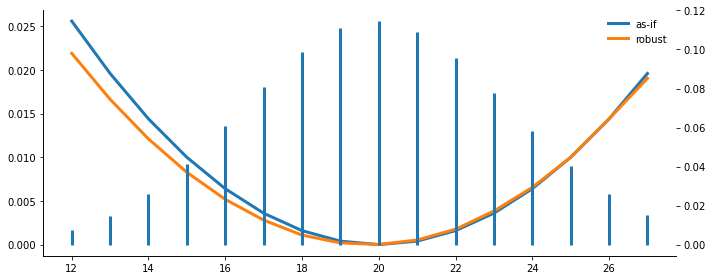

In [8]:
p = 0.4
rv = binom(n, p)
r = np.arange(binom.ppf(0.01, n, p), binom.ppf(0.99, n, p))

fig, ax = plt.subplots(figsize=(10,4))
ax2 = ax.twinx()
#pd.Series(rv.pmf(r), index=r).plot(kind="bar", ax=ax2)
ax2.vlines(r, 0, rv.pmf(r))

ax.plot(r, get_loss(r/n, p), label="as-if")
ax.plot(r, get_loss(get_worst_from_samples(worst_on_sample, r/n), p), label="robust")
ax.legend()

In [9]:
p_1 = 0.5
p_2 = 0.7
rv_1 = binom(n, p_1)
rv_2 = binom(n, p_2)


r_1 = np.arange(binom.ppf(0.01, n, p_1), binom.ppf(0.99, n, p_1))
r_2 = np.arange(binom.ppf(0.01, n, p_2), binom.ppf(0.99, n, p_2))


df = pd.DataFrame(None, columns=[1, 2], index=["robust", "as-if"])
df.index.names = ["Strategy"]

df.loc["as-if", 1] = np.dot(rv_1.pmf(r_1), get_loss(r_1/n, p_1))
df.loc["as-if", 2] = np.dot(rv_2.pmf(r_2), get_loss(r_2/n, p_2))

df.loc["robust", 1] = np.dot(rv_1.pmf(r_1), get_loss(get_worst_from_samples(worst_on_sample, r_1/n), p_1))
df.loc["robust", 2] = np.dot(rv_2.pmf(r_2), get_loss(get_worst_from_samples(worst_on_sample, r_2/n), p_2))

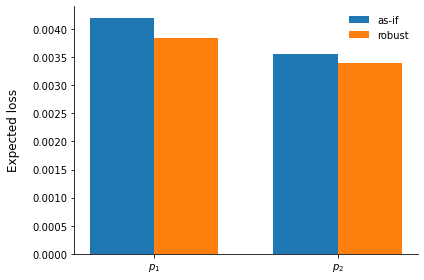

In [10]:
x = np.arange(2)
width = 0.35
fig, ax = plt.subplots()
ax.bar(
    x - width / 2,
    df.loc["as-if"],
    width,
    label="as-if",
)
ax.bar(
    x + width / 2,
    df.loc["robust"],
    width,
    label="robust",
)
ax.set_ylabel("Expected loss")
# ax.set_ylim([0, 0.2])
# ax.set_yticks(np.arange(0, 0.25, 0.05))
ax.set_xticks([0, 1])
ax.set_xticklabels(["$p_1$", "$p_2$"])
ax.legend()

In [11]:
losses_robust = np.empty((len(prob_grid), num_experiments))
expeced_losses_robust = np.empty_like(prob_grid)
max_losses_robust = np.empty_like(prob_grid)
for i, prob in enumerate(prob_grid):
    sampled_probs = np.random.binomial(n, prob, num_experiments) / n
    losses = get_loss(get_worst_from_samples(worst_on_sample, sampled_probs), prob)
    losses_robust[i, :] = losses
    expeced_losses_robust[i] = np.mean(losses)
    max_losses_robust[i] = np.max(losses)

In [12]:
filter_exp_loss_as_if = savgol_filter(expeced_losses_as_if, 29, 3)
filter_exp_loss_robust = savgol_filter(expeced_losses_robust, 29, 3)

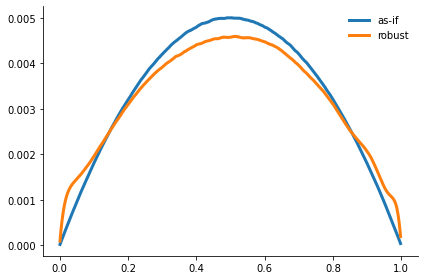

In [13]:
fig, ax = plt.subplots()
ax.plot(prob_grid, filter_exp_loss_as_if, label="as-if")
ax.plot(prob_grid, filter_exp_loss_robust, label="robust")
# ax.plot(np.linspace(0, 1, 1000), risk_function(n, "as-if"), label="as-if")
ax.legend()

In [14]:
filter_max_loss_as_if = savgol_filter(max_losses_as_if, 29, 3)
filter_max_loss_robust = savgol_filter(max_losses_robust, 29, 3)

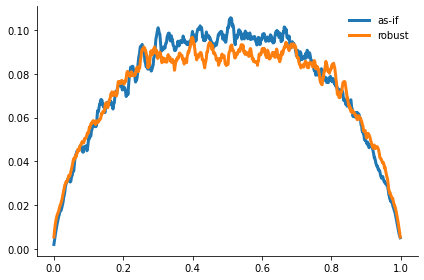

In [15]:
fig, ax = plt.subplots()
ax.plot(prob_grid, filter_max_loss_as_if, label="as-if")
ax.plot(prob_grid, filter_max_loss_robust, label="robust")
ax.legend()